<a href="https://colab.research.google.com/github/WesleyHung/comp3359-Emotion-Analysis/blob/master/project_machine_v2.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comp3359 Project
# Emotion Analysis AI machine


Listed some styles of our machine here...
*   Text classification
*   Supervised learning
*   LSTM (Type of RNN)
*   Attention Mechanism (encoding/ decoding)



# Load the data

In [162]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Specify directory of course materials in Google Drive
module_dir = '/content/drive/My Drive/'

# Path to data file
#I put my dataset in my google drive, you can do so by copying from the sharing file
data_path = os.path.join(module_dir, 'text_emotion.csv')
  
#Loading the dataset into pandas DataFrame
data_df = pd.read_csv(data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


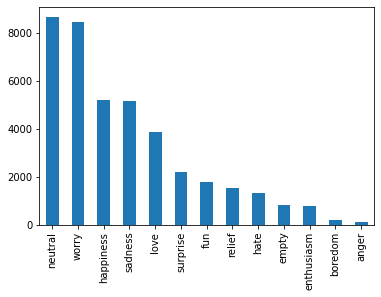

In [61]:
# Plot label histogram
data_df.sentiment.value_counts().plot.bar()

In [149]:
data_df

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
...,...,...,...,...
39995,1753918954,neutral,showMe_Heaven,@JohnLloydTaylor
39996,1753919001,love,drapeaux,Happy Mothers Day All my love
39997,1753919005,love,JenniRox,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,ipdaman1,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


Taking the only useful features

In [163]:
data_df = data_df[['sentiment', 'content']]

for i in range(len(data_df)):
  new_data_df = list(data_df.content[i].split(" "))
  new_data_df = [x for x in new_data_df if not x.startswith('@')]
  data_df.content[i] = " ".join(new_data_df)


'We want to trade with someone who has Houston tickets, but no one will.'

In [164]:
data_df

,sentiment,content
0,empty,i know i was listenin to bad habit earlier an...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,We want to trade with someone who has Houston ...
...,...,...
39995,neutral,
39996,love,Happy Mothers Day All my love
39997,love,Happy Mother's Day to all the mommies out ther...
39998,happiness,WASSUP BEAUTIFUL!!! FOLLOW ME!! PEEP OUT MY N...


## Halves the dataset that has too much emotion (no good performance)


In [62]:
worry_df = data_df.loc[data_df['sentiment']=='worry']
neutral_df = data_df.loc[data_df['sentiment']=='neutral']

# halves the amount of the dataframe
new_worry_size = len(worry_df)//2
new_neutral_size = len(neutral_df)//2

worry_df = worry_df.iloc[:new_worry_size]
neutral_df = neutral_df.iloc[:new_neutral_size]

,tweet_id,sentiment,author,content
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to...
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down
11,1956969531,worry,dudeitsmanda,Choked on her retainers
18,1956971473,worry,LCJ82,@PerezHilton lady gaga tweeted about not being...
20,1956971981,worry,andreagauster,@raaaaaaek oh too bad! I hope it gets better. ...
...,...,...,...,...
13498,1964053218,worry,meldiane,@chelseytx I don't have the app that does it
13499,1964053324,worry,Lena81,Oh no!!!!! It's raining on our Sea World parad...
13501,1964053424,worry,Treeflower86,@shanedawson YOU SHOULD TOUR!! *lol* I live al...
13502,1964053771,worry,Cherye101,is very angrrry! my FB account just got delete...


In [0]:
#drop all the worry label and neutral label from the original dataframe first
data_df = data_df[data_df.sentiment != 'worry']
data_df = data_df[data_df.sentiment != 'neutral']

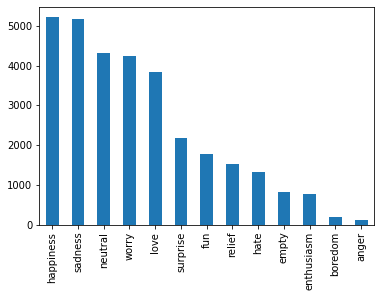

In [64]:
#insert the new worry and neutral datafreame back again
data_df = data_df.append(worry_df)
data_df = data_df.append(neutral_df)

data_df.sentiment.value_counts().plot.bar()

## Delete the dataset that has too few emotion

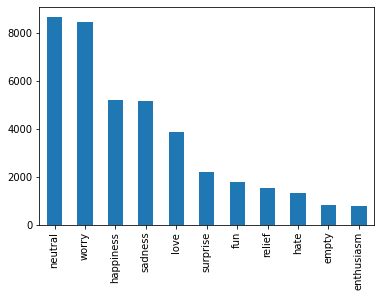

In [165]:
#drop all the label which has too few dataset
data_df = data_df[data_df.sentiment != 'anger']
data_df = data_df[data_df.sentiment != 'boredom']

data_df.sentiment.value_counts().plot.bar()

# Separate Training/Test Dataset

## Global variable

In [0]:
# Random seed for all random process we will use.
RAND_SEED = 3359
# Size of training dataset (the rest, i.e., 20%,  will be test data)
TRAIN_SIZE = 0.8

## Seperate dataset

In [167]:
all_idx = list(range(len(data_df)))

# Shuffle the list of indices
import random
random.seed(RAND_SEED)
random.shuffle(all_idx)

# Split the random indices into two portion according 
# to the training size defined
p = int(len(data_df) * TRAIN_SIZE)
train_idx = all_idx[:p]
test_idx = all_idx[p:]

# Now, retrieve training/test data records from data_df 
# according to the indices we prepared in train_idx and test_idx
train_df = data_df.iloc[train_idx]
test_df = data_df.iloc[test_idx]

# However, since the original indices from data_df will be attached to 
# the retrieved records in train_df and test_df,
# we need to reset index so indices in train_df/test_df will start from 0 as usual
train_df = train_df.reset_index()
test_df = test_df.reset_index()

# Drop the automatically created "index" column
train_df = train_df.drop(['index'], axis=1)
test_df = test_df.drop(['index'], axis=1)

train_df.head()

,sentiment,content
0,worry,These nice boys realized that we were too shor...
1,hate,ugh! Fuck it. Today doesn't look like it's goi...
2,worry,yeah I know! other than youtube rip I don't kn...
3,love,The fever's gone ... Thanks Jen!
4,worry,yeah &amp; when it goes wrong it's the worst f...


# Preprossesing the data

## Stopword Removal using NLTK

In [168]:
# The following code is to remove stop words from sentence using nltk
# Created by - ANALYTICS VIDHYA

# importing libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

# set of stop words
stop_words = set(stopwords.words('english')) 

# tokens of words
nltk.download('punkt')  

for i in range(len(train_df)):

  train_word_tokens = word_tokenize(train_df['content'][i])
  train_filtered_sentence = []
  
  for w in train_word_tokens: 
    if w not in stop_words: 
      train_filtered_sentence.append(w)
  train_df['content'][i] = " ".join(train_filtered_sentence)


for i in range(len(test_df)):

  test_word_tokens = word_tokenize(test_df['content'][i])
  test_filtered_sentence = []
  
  for w in test_word_tokens: 
    if w not in stop_words:
      test_filtered_sentence.append(w) 
  test_df['content'][i] = " ".join(test_filtered_sentence)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Tokenize 'content' using NLTK Treebank Word Tokenizer

In [0]:
from nltk.tokenize import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

for i in range(len(train_df)):

  train_word_tokens = tokenizer.tokenize(train_df.content[i])
  #train_df['content'][i] = train_word_tokens
  train_df['content'][i] = " ".join(train_word_tokens)
  
for i in range(len(test_df)):

  test_word_tokens = tokenizer.tokenize(test_df.content[i])
  #test_df['content'][i] = test_word_tokens
  test_df['content'][i] = " ".join(test_word_tokens)


In [111]:
test_df.content

0          @ irgxana I know ... kittie professional ... .
1       @ AceConcierge Glad got safe & amp ; saw daugh...
2                                  heading baguio hours .
3       @ gfalcone601 giii help really wana find gorge...
4       Home Whitney 's . No sleep . Church bit . Dang...
                              ...                        
7938                              got back home ... bored
7939    Happy Mother 's Day beautiful Moms . ( I 'm ki...
7940    rumage around topless freezer find something e...
7941                       @ AbeerforBill playing journey
7942                  Hate song ? http : //blip.fm/~5jg6f
Name: content, Length: 7943, dtype: object

## Applying byte pair encoding to word segmentation on 'content'

In [0]:
# we use the folowwing module for word segmentation
#!pip install subword-nmt

#extract the 'content' data as we only need the content to be segmented
train_df_content = train_df['content']
test_df_content = test_df['content']

f_train = open("train_content.txt", "a")
f_test = open("test_content.txt", "a")

for content in train_df_content:
  f_train.write(content + '\n')

for content in test_df_content:
  f_test.write(content + '\n')

f_train.close()
f_test.close()

In [0]:
# parameteres for the following command 
num_operations=20000

codes_file = '/content/new_bpe.20000'
train_df_content = '/content/train_content.txt'
test_df_content = '/content/test_content.txt'

bpe_train_df_content = '/content/bpe_train_content.txt'
bpe_test_df_content = '/content/bpe_test_content.txt'

In [0]:
# learn sub-word from train and test data content
!subword-nmt learn-bpe -s {num_operations} < {train_df_content} > {codes_file}
!subword-nmt learn-bpe -s {num_operations} < {test_df_content} > {codes_file}

In [0]:
#start BPE word segmentation
!subword-nmt apply-bpe -c {codes_file} < {train_df_content} > {bpe_train_df_content}
!subword-nmt apply-bpe -c {codes_file} < {test_df_content} > {bpe_test_df_content}

In [0]:
f_train = open("bpe_train_df_content.txt", "a")
f_train.write('bpe_content\n')  # make a name for the data

f_train_content = open("bpe_train_content.txt", "r")
for content in f_train_content:
  f_train.write(content)
f_train_content.close()
f_train.close()



f_test = open("bpe_test_df_content.txt", "a")
f_test.write('bpe_content\n')   # make a name for the data

f_test_content = open("bpe_test_content.txt", "r")

for content in f_test_content:
  f_test.write(content)
f_test_content.close()
f_test.close()


In [174]:
# convert .txt format back to .csv format
bpe_train_content_df = pd.read_fwf('bpe_train_df_content.txt')
bpe_train_content_df = bpe_train_content_df[['bpe_content']]

bpe_test_content_df = pd.read_fwf('bpe_test_df_content.txt')
bpe_test_content_df = bpe_test_content_df[['bpe_content']]\

#merge them back to dataframe format
train_df['bpe_content'] = bpe_train_content_df
test_df['bpe_content'] = bpe_test_content_df

#convert them to string type
train_df.bpe_content = train_df.bpe_content.astype(str)
test_df.bpe_content = test_df.bpe_content.astype(str)

train_df.dtypes

sentiment      object
content        object
bpe_content    object
dtype: object

In [175]:
train_df

,sentiment,content,bpe_content
0,worry,These nice boys realized short see concert mov...,These nice boys realized short see concert mov...
1,hate,ugh ! Fuck . Today n't look like 's going work...,ugh ! Fuck . Today n't look like 's going work...
2,worry,yeah I know ! youtube rip I n't know keep .,yeah I know ! youtube rip I n't know keep .
3,love,The fever 's gone ... Thanks Jen !,The fever 's gone ... Thanks Jen !
4,worry,yeah & amp ; goes wrong 's worst feeling ever,yeah & amp ; goes wrong 's worst feeling ever
...,...,...,...
31763,worry,Have slept afternoon evening getting back NYC ...,Have slept afternoon evening getting back NYC ...
31764,neutral,.,.
31765,worry,okey,o@@ key
31766,happiness,fun b-day celebration .,fun b-day celebr@@ ation .


## Label the emotions as target

In [0]:
labels = train_df["sentiment"].values.tolist()
val_labels = test_df["sentiment"].values.tolist()

## Creating list of emotions

In [177]:
label2id = dict()
label2id = {l: i for i, l in enumerate(set(labels))}
print(label2id)
id2label = {v: k for k, v in label2id.items()}
print(id2label)

{'relief': 0, 'fun': 1, 'sadness': 2, 'enthusiasm': 3, 'worry': 4, 'neutral': 5, 'love': 6, 'surprise': 7, 'empty': 8, 'happiness': 9, 'hate': 10}
{0: 'relief', 1: 'fun', 2: 'sadness', 3: 'enthusiasm', 4: 'worry', 5: 'neutral', 6: 'love', 7: 'surprise', 8: 'empty', 9: 'happiness', 10: 'hate'}


## Encoding the training dataset and validation dataset

In [178]:
max_words = 0 # maximum number of words in a sentence

word2id = dict()

# Construction of word2id dict
for content in train_df.bpe_content:
    for word in content:
        # Add words to word2id dict if not exist
        if word not in word2id:
            word2id[word] = len(word2id)
    # If length of the sentence is greater than max_words, update max_words
    if len(content) > max_words:
        max_words = len(content)

for content in test_df.bpe_content:
    for word in content:
        # Add words to word2id dict if not exist
        if word not in word2id:
            word2id[word] = len(word2id)
    # If length of the sentence is greater than max_words, update max_words
    if len(content) > max_words:
        max_words = len(content)

max_words

152

## Encoding train(content) and labels(sentiment) to corresponing integer values

In [179]:
#reference to the online material
import keras

# Encode input words and labels
train = [[word2id[word] for word in sentence] for sentence in train_df.content]
val = [[word2id[word] for word in sentence] for sentence in test_df.content]
Y = [label2id[label] for label in labels]
val_Y = [label2id[label] for label in val_labels]

# Apply Padding to X
from keras.preprocessing.sequence import pad_sequences
train = pad_sequences(train, max_words)
val = pad_sequences(val, max_words)

# Convert Y to numpy array
Y = keras.utils.to_categorical(Y, num_classes=len(label2id), dtype='float32')
val_Y = keras.utils.to_categorical(val_Y, num_classes=len(label2id), dtype='float32')

# Print shapes
print("Shape of train: {}".format(train.shape))
print("Shape of Y: {}".format(Y.shape))
print("-------------")
print("Shape of val: {}".format(val.shape))
print("Shape of val_Y: {}".format(val_Y.shape))
print("-------------")
print(len(word2id))

Shape of train: (31768, 152)
Shape of Y: (31768, 11)
-------------
Shape of val: (7943, 152)
Shape of val_Y: (7943, 11)
-------------
98


In [0]:
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """

    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    print(x_train[1])

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    
    if max_length > MAX_SEQUENCE_LENGTH:
      max_length = MAX_SEQUENCE_LENGTH
    
    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index, max_length

In [129]:
#tokenize the train dataset and test dataset 
train, val, word_index, max_words = sequence_vectorize(train_df['bpe_content'], test_df['bpe_content'])

print(train[1])
print(train_df.bpe_content[1])
max_words

[8208, 216, 505, 15, 3, 132, 8, 2, 16, 14, 4, 65]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0 8208  216  505   15    3  132    8    2   16
   14    4   65]
@ lexiloohoo ugh ! Fuck . Today n't look like 's going work 'm sorry


31

# Build LSTM model with attention

In [180]:
embedding_dim = 100 # The dimension of word embeddings

# Define input tensor
sequence_input = keras.Input(shape=(max_words,), dtype='int32')

# Word embedding layer
embedded_inputs =keras.layers.Embedding(len(train) + 1,
                                        embedding_dim,
                                        input_length=max_words)(sequence_input)

# Apply dropout to prevent overfitting
embedded_inputs = keras.layers.Dropout(0.2)(embedded_inputs)

# Apply Bidirectional LSTM over embedded inputs
lstm_outs = keras.layers.wrappers.Bidirectional(
    keras.layers.LSTM(embedding_dim, return_sequences=True)
)(embedded_inputs)

# Apply dropout to LSTM outputs to prevent overfitting
lstm_outs = keras.layers.Dropout(0.2)(lstm_outs)


# Attention Mechanism - Generate attention vectors
input_dim = int(lstm_outs.shape[2])
permuted_inputs = keras.layers.Permute((2, 1))(lstm_outs)
attention_vector = keras.layers.TimeDistributed(keras.layers.Dense(1))(lstm_outs)
attention_vector = keras.layers.Reshape((max_words,))(attention_vector)
attention_vector = keras.layers.Activation('softmax', name='attention_vec')(attention_vector)
attention_output = keras.layers.Dot(axes=1)([lstm_outs, attention_vector])

# Last layer: fully connected with softmax activation
fc = keras.layers.Dense(embedding_dim, activation='relu')(attention_output)
output = keras.layers.Dense(len(label2id), activation='softmax')(fc)

# Finally building model
model = keras.Model(inputs=[sequence_input], outputs=output)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

# Print model summary
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 152)          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 152, 100)     3176900     input_6[0][0]                    
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 152, 100)     0           embedding_6[0][0]                
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 152, 200)     160800      dropout_11[0][0]                 
____________________________________________________________________________________________

# Train the model

In [181]:
# Train model 10 iterations
history = model.fit(train, Y, epochs=10, batch_size=128, validation_split=0.1, shuffle=True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 28591 samples, validate on 3177 samples
Epoch 1/10
28591/28591 [==============================] - 104s 4ms/step - loss: 2.1172 - accuracy: 0.2337 - val_loss: 2.0981 - val_accuracy: 0.2468
Epoch 2/10
28591/28591 [==============================] - 103s 4ms/step - loss: 2.0640 - accuracy: 0.2658 - val_loss: 2.0750 - val_accuracy: 0.2606
Epoch 3/10
28591/28591 [==============================] - 103s 4ms/step - loss: 2.0402 - accuracy: 0.2798 - val_loss: 2.0539 - val_accuracy: 0.2776
Epoch 4/10
28591/28591 [==============================] - 103s 4ms/step - loss: 2.0199 - accuracy: 0.2910 - val_loss: 2.0405 - val_accuracy: 0.2871
Epoch 5/10
28591/28591 [==============================] - 104s 4ms/step - loss: 2.0059 - accuracy: 0.2983 - val_loss: 2.0270 - val_accuracy: 0.2927
Epoch 6/10
28591/28591 [==============================] - 103s 4ms/step - loss: 1.9961 - accuracy: 0.3042 - val_loss: 2.0223 - val_accuracy: 0.2858
Epoch 7/10
28591/28591 [==============================] - 103s 

In [0]:
import torch
from torchvision import datasets, models, transforms

model_save_name = "lstm_attention_v2.1_trained.h5" 
path = F"/content/drive/My Drive/Colab Notebooks/{model_save_name}" 
#torch.save(model.state_dict(), path)
model.save(path)

If you want to use the existing model, I've already store it in our shared file. 

In [0]:
"""
!pip install gdown==3.6.0

v1_id = "1M1VxKSiCgecAkogInyEwc4Phx3b9PzbF"
v2_id = "1-AbA0OevJmKWaknYsmGRSfYzwsM7IlU2"
v2.1_id = ""

#!gdown https://drive.google.com/uc?id={v1_id}  #v1_model
#!gdown https://drive.google.com/uc?id={v2_id}  #v2_model
"""

'\n!pip install gdown==3.6.0\n\nv1_id = "1M1VxKSiCgecAkogInyEwc4Phx3b9PzbF"\nv2_id = "1-AbA0OevJmKWaknYsmGRSfYzwsM7IlU2"\n\n#!gdown https://drive.google.com/uc?id={v1_id}  #v1_model\n#!gdown https://drive.google.com/uc?id={v2_id}  #v2_model\n'

In [0]:
"""
import keras
model_from_drive = keras.models.load_model('lstm_attention_v1_trained.h5')
"""

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# Testing and predicting

## Test

In [182]:

# Create a new model instance
#If you using the loaded model, uncomment this line:
#model = model_from_drive


# Re-evaluate the model
loss, acc = model.evaluate(val, val_Y, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))


Restored model, accuracy: 31.32%


## Predict

In [51]:
# Re-create the model to get attention vectors as well as label prediction
model_with_attentions = keras.Model(inputs=model.input,
                                    outputs=[model.output, 
                                             model.get_layer('attention_vec').output])

"""
# If you just use the downloaded model wothout trained yourself, please use here:
model_with_attentions = keras.Model(inputs=model_from_drive.input,
                                    outputs=[model_from_drive.output, 
                                             model_from_drive.get_layer('attention_vec').output])
"""

"\n# If you just use the downloaded model wothout trained yourself, please use here:\nmodel_with_attentions = keras.Model(inputs=model_from_drive.input,\n                                    outputs=[model_from_drive.output, \n                                             model_from_drive.get_layer('attention_vec').output])\n"

In [183]:
import random
import math

# Select random samples to illustrate
sample_text = "what are you doing"
sample_text = sample_text.lower()
#sample_text = random.choice(val)


# Encode samples
tokenized_sample = sample_text.split(" ")
encoded_samples = [[word_index[word] for word in tokenized_sample]]

# Padding
encoded_samples = keras.preprocessing.sequence.pad_sequences(encoded_samples, maxlen=max_words)

#encoded_samples = sample_text
#print(encoded_samples.shape)
# Make predictions
label_probs, attentions = model_with_attentions.predict(encoded_samples)
label_probs = {id2label[_id]: prob for (label, _id), prob in zip(label2id.items(),label_probs[0])}

# Get word attentions using attenion vector
token_attention_dic = {}
max_score = 0.0
min_score = 0.0
for token, attention_score in zip(tokenized_sample, attentions[0][-len(tokenized_sample):]):
    token_attention_dic[token] = math.sqrt(attention_score)


# VISUALIZATION
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
    
def attention2color(attention_score):
    r = 255 - int(attention_score * 255)
    color = rgb_to_hex((255, r, r))
    return str(color)
    
# Build HTML String to viualize attentions
html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
for token, attention in token_attention_dic.items():
    html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention),
                                                                        token)
html_text += "</p>"
# Display text enriched with attention scores 
display(HTML(html_text))

# PLOT EMOTION SCORES
emotions = [label for label, _ in label_probs.items()]
scores = [score for _, score in label_probs.items()]
plt.figure(figsize=(5,2))
plt.bar(np.arange(len(emotions)), scores, align='center', alpha=0.5, color=['black', 'red', 'green', 'blue', 'cyan', "purple"])
plt.xticks(np.arange(len(emotions)), emotions)
plt.ylabel('Scores')
plt.show()


NameError: ignored

In case the above chart is hard to see, here is the list of proboabilities showing the likeliness of emotions.

In [55]:
import operator

# create a list of emotion in decending order of their probability 
emotion_list=[]

for  _, emotion in enumerate(label_probs):
    temp = [emotion, label_probs[emotion]]
    emotion_list.append(temp)

sorted(emotion_list, key=operator.itemgetter(1), reverse= True)

[['worry', 0.35792974],
 ['neutral', 0.260627],
 ['sadness', 0.226002],
 ['surprise', 0.09963546],
 ['hate', 0.024357434],
 ['empty', 0.013586671],
 ['love', 0.011085417],
 ['relief', 0.0026744956],
 ['boredom', 0.0013502156],
 ['enthusiasm', 0.0011065771],
 ['anger', 0.0008735581],
 ['happiness', 0.00047115175],
 ['fun', 0.0003002882]]

# Serveral gusses of improving the model 

*   half the data with labels of many dataset (not brings a sufficient performance)
*   cut out the label with too few dataset
*   using sub-wording tokenization
*   hyperparameter tuning
*   NOT CONVERGE
*   model achtecture re-design
*   remove stop words (e.g. there, is, a, ...)
*   tag name (with prefix '@') removal

